# This notebook exhibits a few plots for the data tiers

In [2]:
#This notebook was created on local systems.
#To use this notebook on SageMaker, users will
#need to load the data from the wrf-cmip6-noversioning
#bucket using the specific AWS library calls. For more information,
#see https://docs.aws.amazon.com/sagemaker/latest/dg/gs-setup-working-env.html

In [32]:
#Functions and otherwise...

from netCDF4 import Dataset
import pylab as P
import numpy as np
from numpy import ma
from numpy import dtype
import matplotlib
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
import xarray as xr
import pandas as pd
import os
from scipy.interpolate import griddata
import wrf
from wrf import (getvar, to_np, vertcross, smooth2d, CoordPair, GeoBounds,
                 get_cartopy, latlon_coords, cartopy_xlim, cartopy_ylim)
import xesmf as xe
import dask
import gc
import datetime
import time
from scipy import stats
import regionmask

states = cfeature.NaturalEarthFeature(category='cultural', scale='50m',
                                      facecolor='none',
                                      name='admin_1_states_provinces_shp')

#Read metadata (wrfinput file)
def _metaread(dir_meta,domain):
 file = "%swrfinput_%s" %(dir_meta,domain)
 data = xr.open_dataset(file)
 lat = data.variables["XLAT"]
 lon = data.variables["XLONG"]
 z = data.variables["HGT"]

 return (lat,lon,z,file)

#WRF reader function
def _wrfread(prefix,dir,var,domain):

 all_files = sorted(os.listdir(dir))

 anal_files = []
 for ii in all_files:
  if ii.startswith(var+"."):
   if domain in ii:
    if prefix in ii:
     anal_files.append(dir+str(ii))

 del all_files

 nf  = len(anal_files)

 data = xr.open_mfdataset(anal_files, combine="by_coords")
 var_read = data.variables[var]
 day = data.variables["day"].values
 nt = len(day)

 day1 = pd.to_datetime(str(int(day[0])), format='%Y-%m-%d')
 day2 = pd.to_datetime(str(int(day[nt-1])), format='%Y-%m-%d')
 dates = pd.date_range(day1,day2,freq="D")

 #Mask array setting leap years = True
 is_leap_day = (dates.month == 2) & (dates.day == 29)
 dates = dates[~is_leap_day]

 var_read = xr.DataArray(var_read, dims=['day','lat2d','lon2d'])
 var_read['day'] = dates    #year doesn't matter here

 return (var_read)

#WRF tier 3 reader function
def _wrfread_gcm(model,gcm,variant,dir,var,domain):

 all_files = sorted(os.listdir(dir))

 anal_files = []
 for ii in all_files:
  if ii.startswith(var+".") and model in ii and gcm in ii \
        and variant in ii and domain in ii:
   if domain in ii:
     anal_files.append(dir+str(ii))

 del all_files

 nf  = len(anal_files)

 data = xr.open_mfdataset(anal_files, combine="by_coords")
 var_read = data.variables[var]
 day = data.variables["day"].values
 nt = len(day)

 day1 = pd.to_datetime(str(int(day[0])), format='%Y-%m-%d')
 day2 = pd.to_datetime(str(int(day[nt-1])), format='%Y-%m-%d')
 dates = pd.date_range(day1,day2,freq="D")

 #Mask array setting leap years = True
 ''' is_leap_day = (dates.month == 2) & (dates.day == 29)
 dates = dates[~is_leap_day]'''

 var_read = xr.DataArray(var_read, dims=['day','lat2d','lon2d'])
 var_read['day'] = dates    #year doesn't matter here

 return (var_read)

def screen_times(data,date_start,date_end):
    #Dimensions should be "time"
    dask.config.set(**{'array.slicing.split_large_chunks': True})
    data = data.sel(time=~((data.time.dt.month < date_start[1]) & (data.time.dt.year <= date_start[0])))
    data = data.sel(time=~((data.time.dt.year < date_start[0])))
    data = data.sel(time=~((data.time.dt.month >= date_end[1]) & (data.time.dt.year >= date_end[0])))
    data = data.sel(time=~((data.time.dt.year > date_end[0])))

    return(data)

def screen_times_wrf(data,date_start,date_end):
    #Dimensions should be "day"
    dask.config.set(**{'array.slicing.split_large_chunks': True})
    data = data.sel(day=~((data.day.dt.month < date_start[1]) & (data.day.dt.year <= date_start[0])))
    data = data.sel(day=~((data.day.dt.year < date_start[0])))
    data = data.sel(day=~((data.day.dt.month >= date_end[1]) & (data.day.dt.year >= date_end[0])))
    data = data.sel(day=~((data.day.dt.year > date_end[0])))
    
    return(data)

def screen_times_wrf_year_only(data,date_start,date_end):
    #Dimensions should be "day"
    dask.config.set(**{'array.slicing.split_large_chunks': True})
    data = data.sel(day=~((data.day.dt.year < date_start[0])))
    data = data.sel(day=~((data.day.dt.year > date_end[0])))
    
    return(data)

print ("Functions loaded")

Functions loaded


# Read in the metadata from the wrfinput files

In [6]:
%%time

#These files contain all static fields
domain = "d01"
dir_meta = "/mnt/parm/raid/data/WRF_2020/meta/meta_new/"
lat1, lon1, z1, file = _metaread(dir_meta,domain)
lon_wrf = lon1[0,:,:]
lat_wrf = lat1[0,:,:]
z_wrf = z1[0,:,:]
lat_wrf = xr.DataArray(lat_wrf, dims=["lat2d", "lon2d"])
lon_wrf = xr.DataArray(lon_wrf, dims=["lat2d", "lon2d"])
z_wrf = xr.DataArray(z_wrf, dims=["lat2d", "lon2d"])

lat_wrf_d01, lon_wrf_d01 = lat_wrf, lon_wrf

domain = "d02"
dir_meta = "/mnt/parm/raid/data/WRF_2020/meta/meta_new/"
lat1, lon1, z1, file = _metaread(dir_meta,domain)
lon_wrf = lon1[0,:,:]
lat_wrf = lat1[0,:,:]
z_wrf = z1[0,:,:]
lat_wrf = xr.DataArray(lat_wrf, dims=["lat2d", "lon2d"])
lon_wrf = xr.DataArray(lon_wrf, dims=["lat2d", "lon2d"])
z_wrf = xr.DataArray(z_wrf, dims=["lat2d", "lon2d"])

lat_wrf_d02, lon_wrf_d02 = lat_wrf, lon_wrf

domain = "d03"
dir_meta = "/mnt/parm/raid/data/WRF_2020/meta/meta_new/"
lat1, lon1, z1, file = _metaread(dir_meta,domain)
lon_wrf = lon1[0,:,:]
lat_wrf = lat1[0,:,:]
z_wrf = z1[0,:,:]
lat_wrf = xr.DataArray(lat_wrf, dims=["lat2d", "lon2d"])
lon_wrf = xr.DataArray(lon_wrf, dims=["lat2d", "lon2d"])
z_wrf = xr.DataArray(z_wrf, dims=["lat2d", "lon2d"])

lat_wrf_d03, lon_wrf_d03 = lat_wrf, lon_wrf

domain = "d04"
dir_meta = "/mnt/parm/raid/data/WRF_2020/meta/meta_new/"
lat1, lon1, z1, file = _metaread(dir_meta,domain)
lon_wrf = lon1[0,:,:]
lat_wrf = lat1[0,:,:]
z_wrf = z1[0,:,:]
lat_wrf = xr.DataArray(lat_wrf, dims=["lat2d", "lon2d"])
lon_wrf = xr.DataArray(lon_wrf, dims=["lat2d", "lon2d"])
z_wrf = xr.DataArray(z_wrf, dims=["lat2d", "lon2d"])

lat_wrf_d04, lon_wrf_d04 = lat_wrf, lon_wrf

print("metadata read for each grid")

metadata read for each grid
CPU times: user 2.36 s, sys: 87.4 ms, total: 2.44 s
Wall time: 2.74 s


# Tier 1 (*wrfout*) and Tier 2 (*auxhist*) files

In [4]:
#Visualizing Tier 1 and Tier 2 data is a similar process.
#We thus focus on a given set of hourly (Tier 2) files from era5.

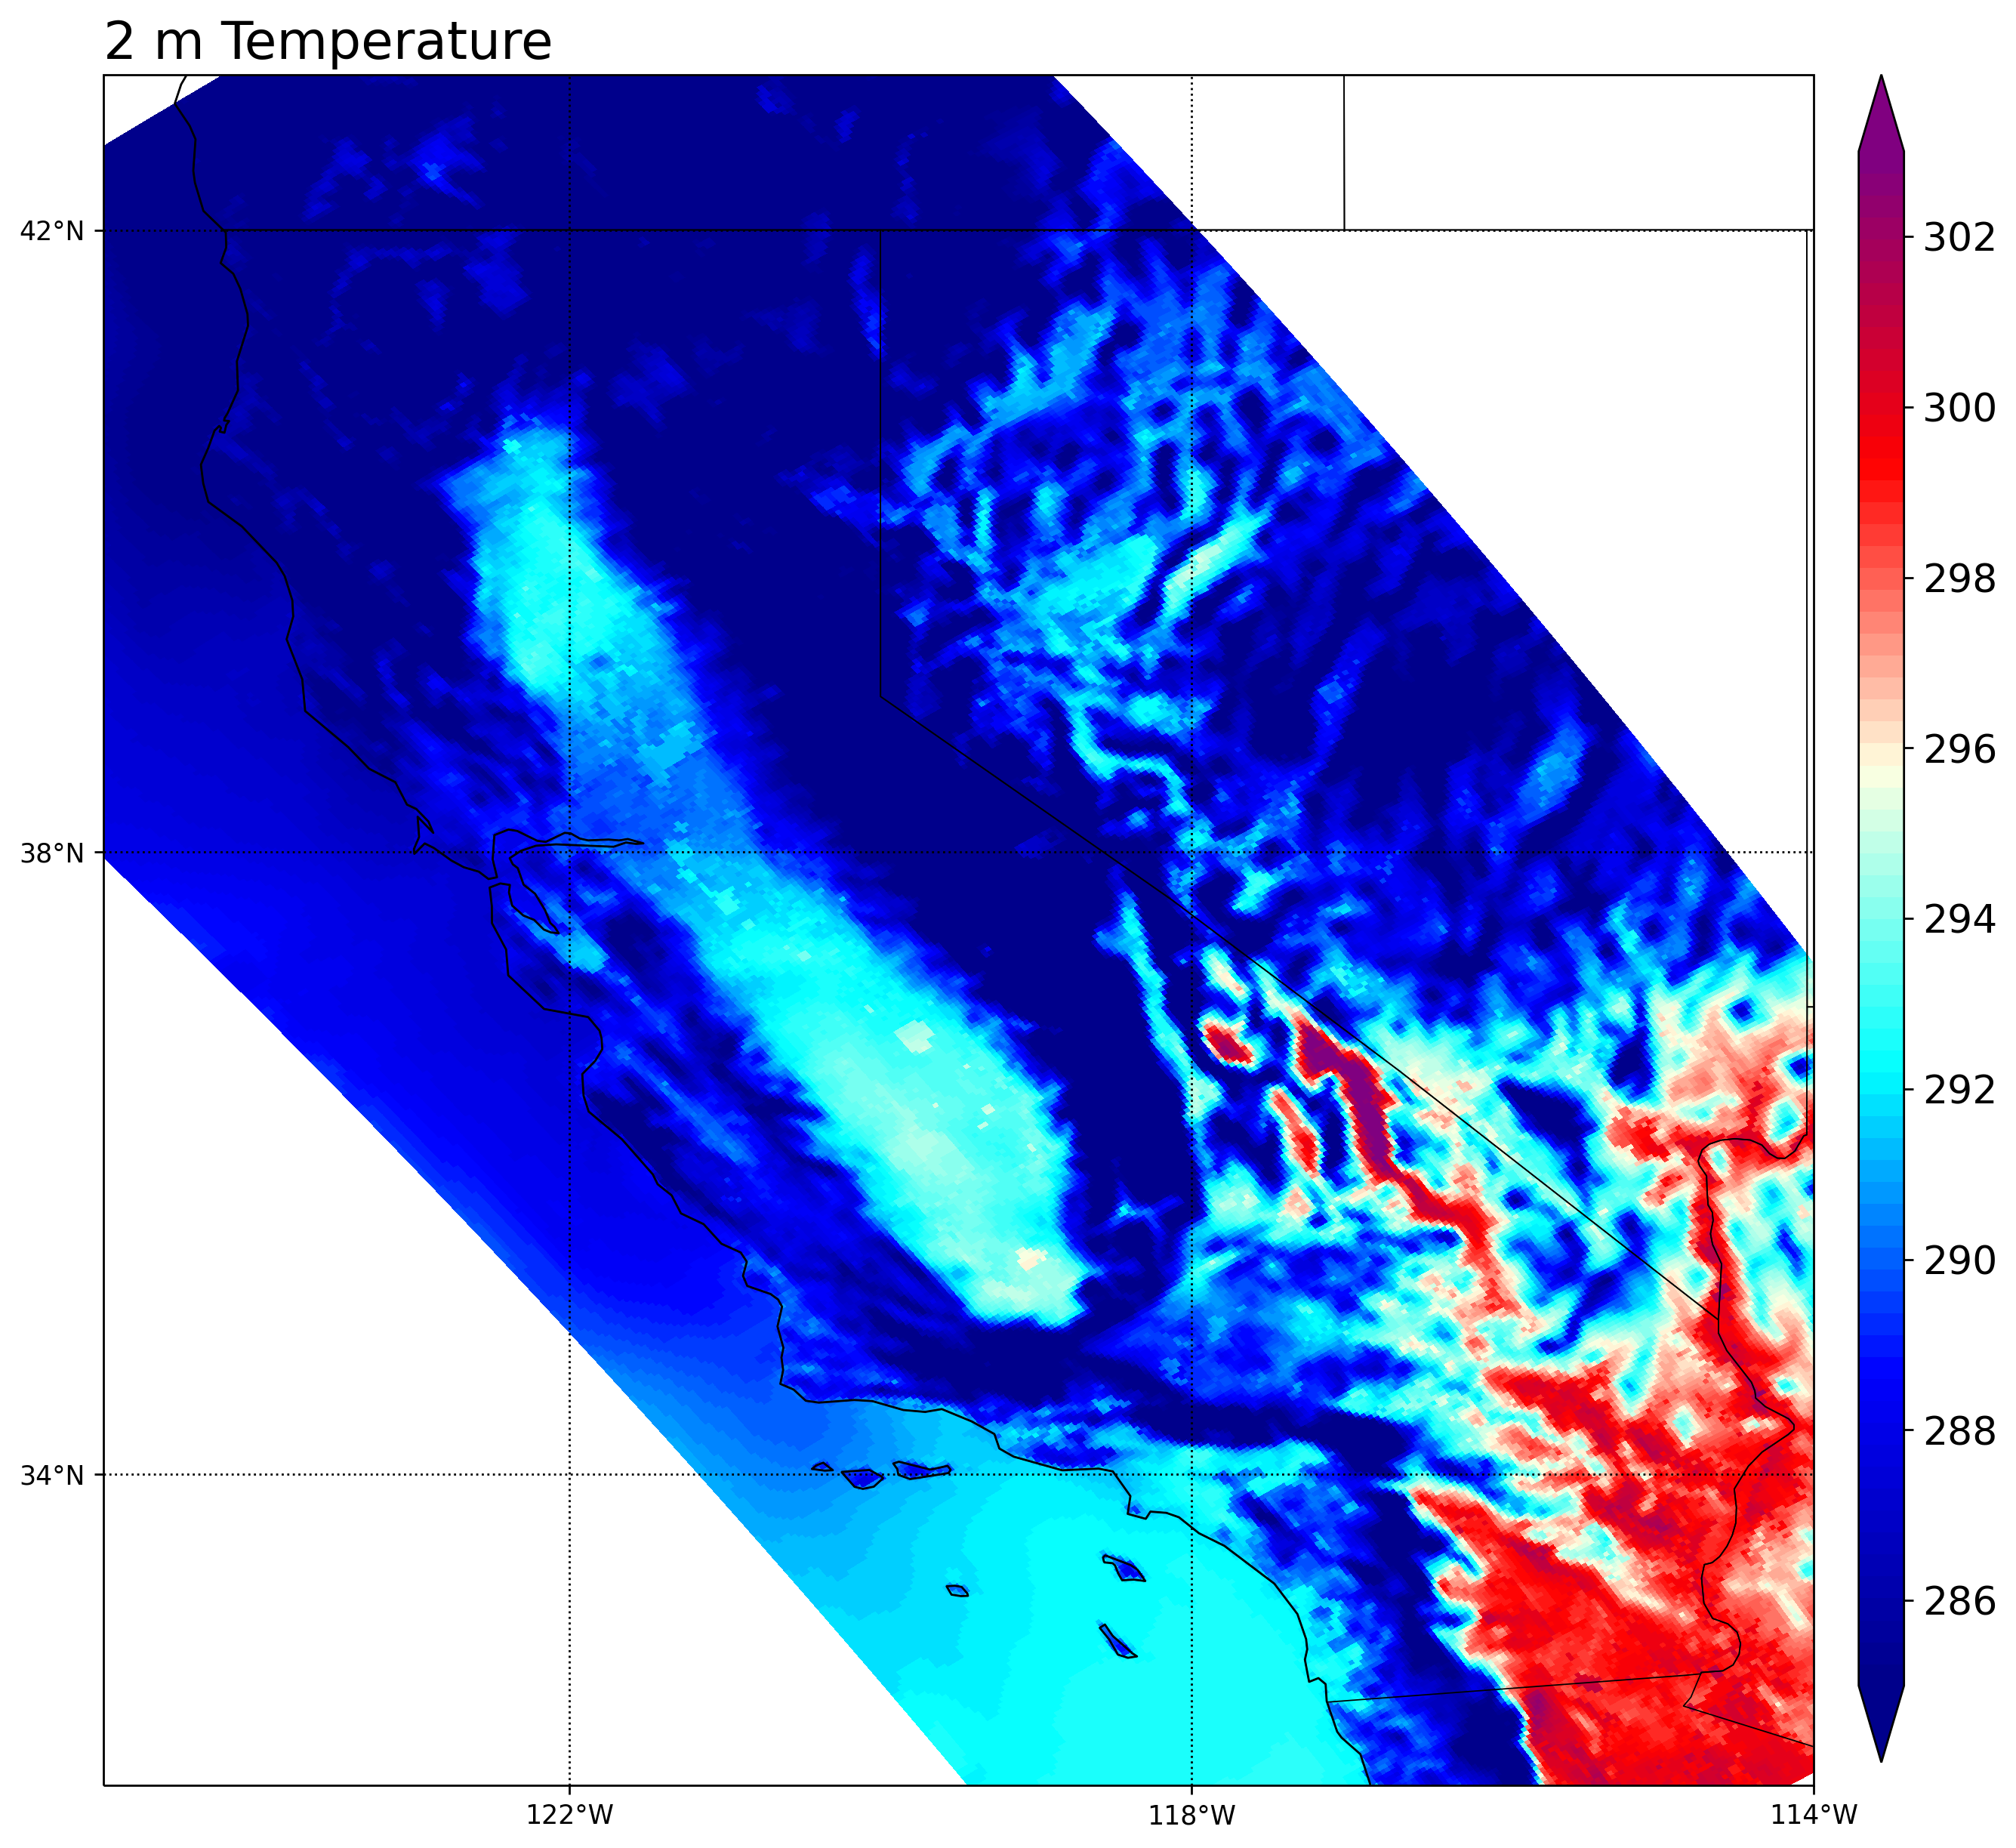

In [29]:
#For Tier 2

#Read files
dir = "/mnt/parm/raid/data/WRF_2020/era/hourly/2000/d03/"

all_files = sorted(os.listdir(dir))

analysis_files = []
for ii in all_files[0:24]:         #Only focus on a single day for example
 analysis_files.append(dir+str(ii))

del all_files

var = 'T2'

lump_in_time = []

for ifile in analysis_files:
 data = xr.open_dataset(ifile)
 lump_in_time.append(data)

#Finalized merged Dataset from which
#we extract the temperature variable
lump_in_time = xr.concat(lump_in_time, dim='Time')

#Averaged in Time
surface_temperature = lump_in_time.variables[var].mean(dim="Time")

#Now plot

#Custom colorbar
levs =  np.array(np.arange(285,305,2))
mycmap = ["darkblue","blue","aqua","lightyellow",
        "red","purple"]

colors_to_rgb = []
for ii in mycmap:
 aa = colors.to_rgba(ii)
 colors_to_rgb.append(aa)
cmap = LinearSegmentedColormap.from_list("t2",colors_to_rgb,70)

#Define the projection
cart_proj = crs.PlateCarree()

fig = P.figure(figsize=(12,12),dpi=250)

ax1 = P.subplot(1,1,1,projection=cart_proj)

txt = "2 m Temperature"
ax1.set_title(txt,fontsize=20,loc="left")

cs = ax1.pcolormesh(lon_wrf_d03,lat_wrf_d03,surface_temperature[:-1,:-1], \
                cmap=cmap, \
                vmin=np.min(levs),vmax=np.max(levs),shading='flat')

ax = [ax1]

lons = np.arange(-170,-60,4)
lats = np.arange(10,70,4)

for iax in ax:
    iax.coastlines('50m', linewidth=0.8)
    iax.add_feature(states, linewidth=.5, edgecolor="black")
    gl = iax.gridlines(crs=cart_proj,color="black", linestyle="dotted", \
                   x_inline=True,y_inline=True)
    gl.xlocator = mticker.FixedLocator(lons)
    gl.ylocator = mticker.FixedLocator(lats)
    iax.set_xticks(np.arange(-170,-60,4),crs=crs.PlateCarree())
    iax.set_yticks(np.arange(10,70,4),crs=crs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    iax.xaxis.set_major_formatter(lon_formatter)
    iax.yaxis.set_major_formatter(lat_formatter)
    
    for tick in iax.xaxis.get_major_ticks():
                tick.label.set_fontsize(10)
    for tick in iax.yaxis.get_major_ticks():
                tick.label.set_fontsize(10)

    iax.set_extent([-125,-114,32,43])

#Get positions for cbs
ax1_pos = ax1.get_position()

cbar_ax = fig.add_axes([ax1_pos.x1+0.02, ax1_pos.y0+0.01, 0.02, ax1_pos.y1 - ax1_pos.y0-0.01]) # bottom left corner x,y, and width, height
cb = P.colorbar(cs,cax=cbar_ax,extend="both",orientation="vertical")
cb.ax.tick_params(labelsize=15)

# Now let's make this more interesting.... use the Tier 3 files to examine the climate change signal for snow water equivalent focusing on a single GCM

CPU times: user 1min 19s, sys: 1min 47s, total: 3min 7s
Wall time: 1min 20s


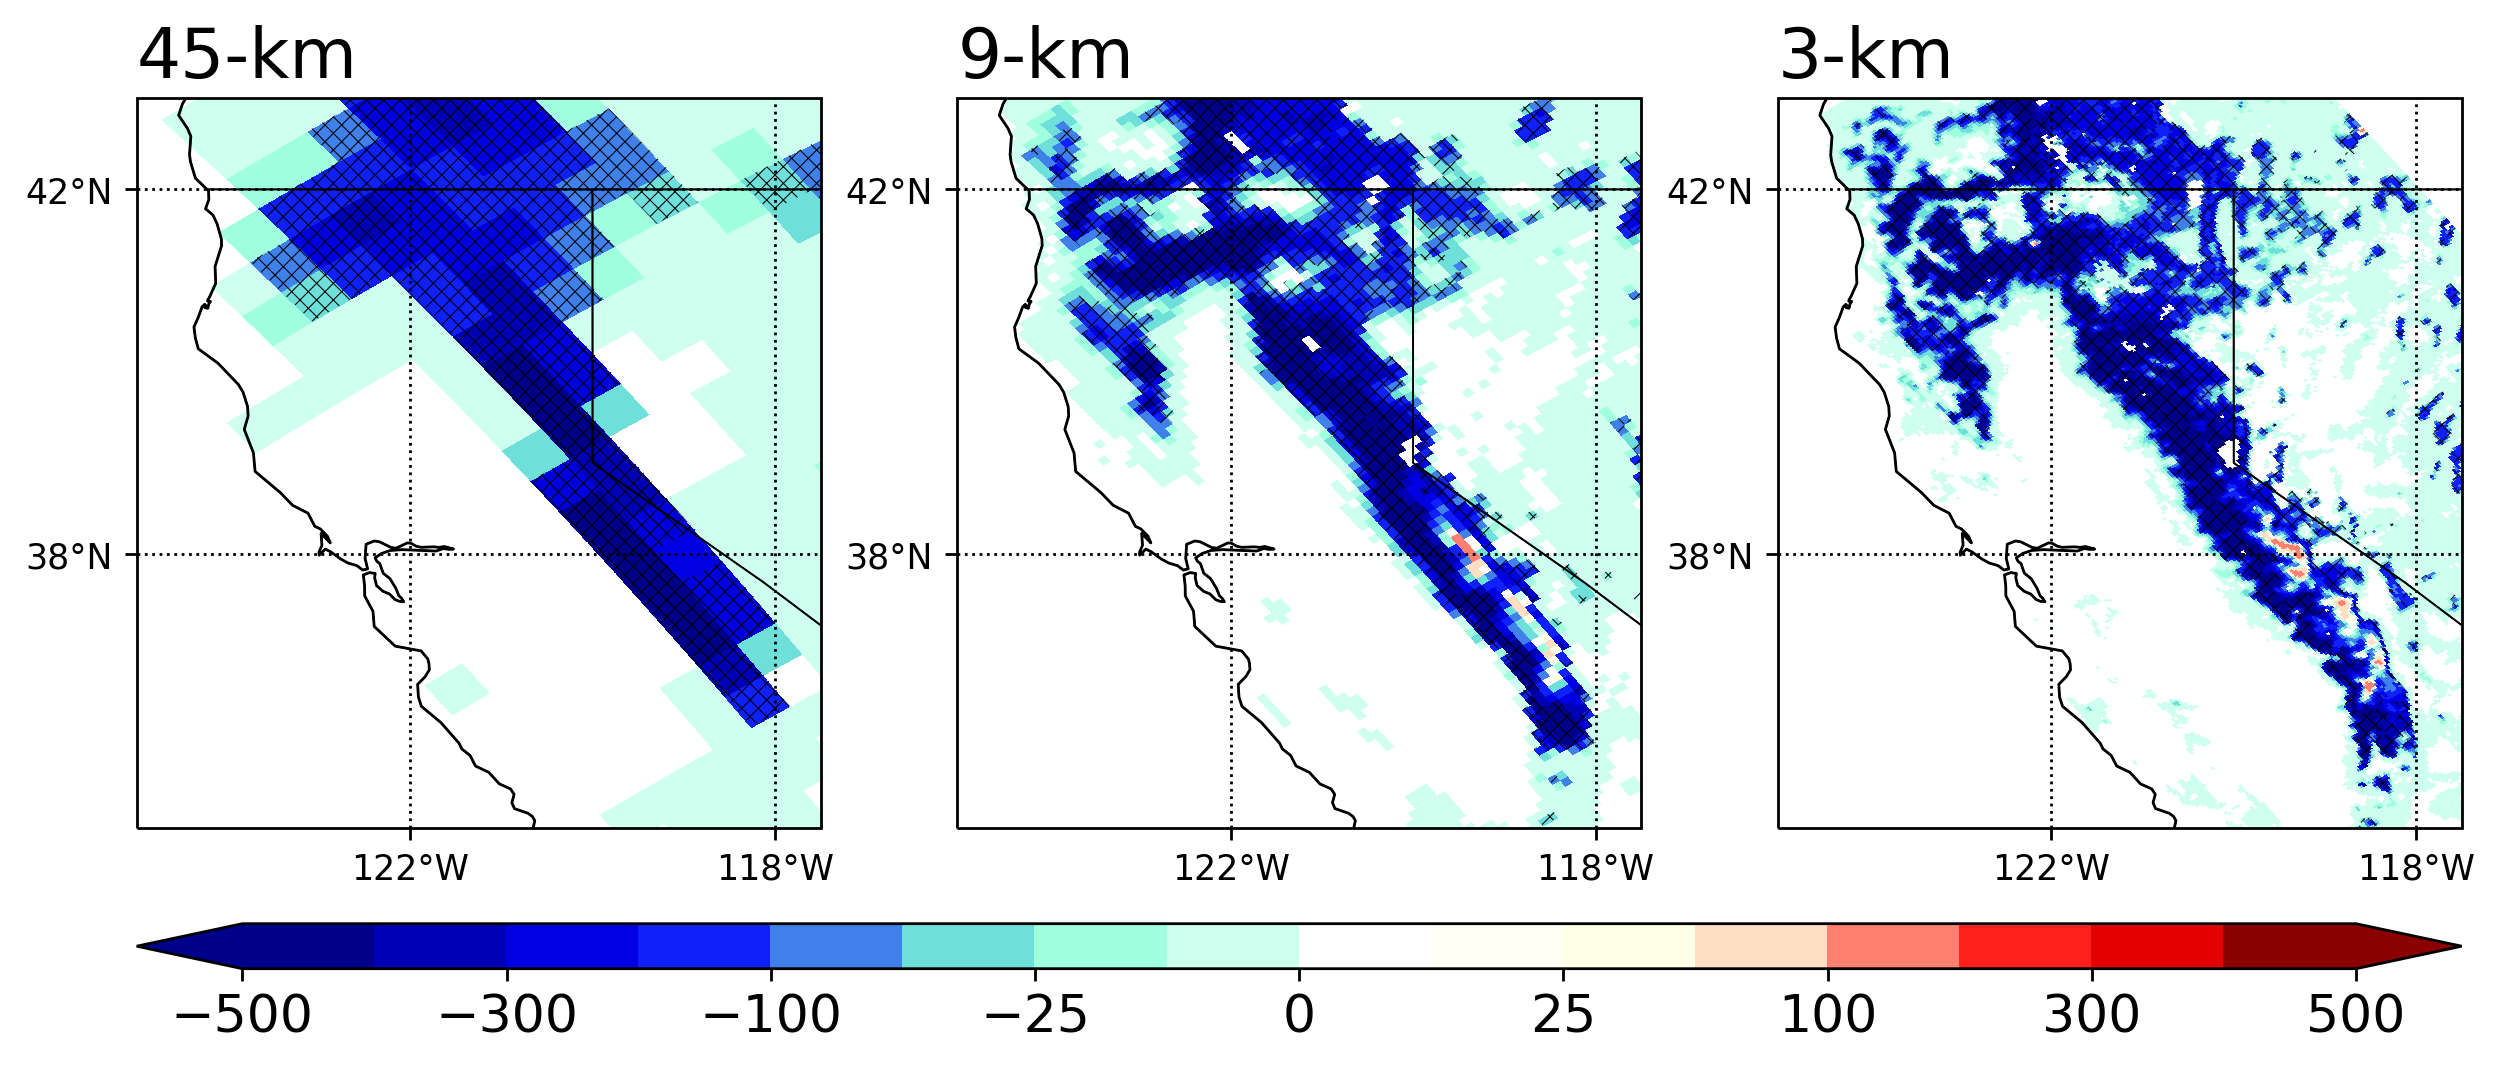

In [54]:
%%time

domain = "d01"

var = 'snow'
gcm = 'mpi-esm1-2-lr'
variant = 'r8i1p1f1'

domain = "d01"
ssp = 'ssp370'
date_start_pd, date_end_pd = [1980,9,1], [2010,9,1]
date_start_ec, date_end_ec = [2070,9,1], [2100,9,1]

model = 'hist'
dir = "/mnt/parm/raid/data/WRF_2020/mpi_r8/postprocess/" + domain + "/"
var_wrf = _wrfread_gcm(model,gcm,variant,dir,var,domain)
var_wrf = screen_times_wrf(var_wrf,date_start_pd,date_end_pd)
var_wrf = var_wrf.sel(day=( (var_wrf.day.dt.month == 4) & (var_wrf.day.dt.day == 1) )  )
y1 = var_wrf
pd_array = var_wrf.mean(dim="day")

model = 'ssp370'
dir = "/mnt/parm/raid/data/WRF_2020/mpi_r8/postprocess/" + domain + "/"
var_wrf = _wrfread_gcm(model,gcm,variant,dir,var,domain)
var_wrf = screen_times_wrf(var_wrf,date_start_ec,date_end_ec)
var_wrf = var_wrf.sel(day=( (var_wrf.day.dt.month == 4) & (var_wrf.day.dt.day == 1) )  )
y2 = var_wrf
ec_array = var_wrf.mean(dim="day")

diff_d01 = y2 - y1
diff_mean_d01 = ec_array - pd_array

#Compute t test
y1 = np.array(y1)
y2 = np.array(y2)

#Mask where < 0.1, 0.05, 0.01, computing t- and p-values
thresh = 0.1
t, p  = stats.ttest_ind(y2,y1,equal_var=False)
p = np.ma.masked_invalid(p)

p1_d01 = np.ma.masked_where(p > thresh, p)
thresh = 0.05
p2_d01 = np.ma.masked_where(p > thresh, p1_d01)
thresh = 0.01
p3_d01 = np.ma.masked_where(p > thresh, p2_d01)

domain = "d02"
ssp = 'ssp370'
date_start_pd, date_end_pd = [1980,9,1], [2010,9,1]
date_start_ec, date_end_ec = [2070,9,1], [2100,9,1]

model = 'hist'
dir = "/mnt/parm/raid/data/WRF_2020/mpi_r8/postprocess/" + domain + "/"
var_wrf = _wrfread_gcm(model,gcm,variant,dir,var,domain)
var_wrf = screen_times_wrf(var_wrf,date_start_pd,date_end_pd)
var_wrf = var_wrf.sel(day=( (var_wrf.day.dt.month == 4) & (var_wrf.day.dt.day == 1) )  )
y1 = var_wrf
pd_array = var_wrf.mean(dim="day")

model = 'ssp370'
dir = "/mnt/parm/raid/data/WRF_2020/mpi_r8/postprocess/" + domain + "/"
var_wrf = _wrfread_gcm(model,gcm,variant,dir,var,domain)
var_wrf = screen_times_wrf(var_wrf,date_start_ec,date_end_ec)
var_wrf = var_wrf.sel(day=( (var_wrf.day.dt.month == 4) & (var_wrf.day.dt.day == 1) )  )
y2 = var_wrf
ec_array = var_wrf.mean(dim="day")

diff_d02 = y2 - y1
diff_mean_d02 = ec_array - pd_array

#Compute t test
y1 = np.array(y1)
y2 = np.array(y2)

#Mask where < 0.1, 0.05, 0.01, computing t- and p-values
thresh = 0.1
t, p  = stats.ttest_ind(y2,y1,equal_var=False)
p = np.ma.masked_invalid(p)

p1_d02 = np.ma.masked_where(p > thresh, p)
thresh = 0.05
p2_d02 = np.ma.masked_where(p > thresh, p1_d02)
thresh = 0.01
p3_d02 = np.ma.masked_where(p > thresh, p2_d02)

domain = "d03"
ssp = 'ssp370'
date_start_pd, date_end_pd = [1980,9,1], [2010,9,1]
date_start_ec, date_end_ec = [2070,9,1], [2100,9,1]

model = 'hist'
dir = "/mnt/parm/raid/data/WRF_2020/mpi_r8/postprocess/" + domain + "/"
var_wrf = _wrfread_gcm(model,gcm,variant,dir,var,domain)
var_wrf = screen_times_wrf(var_wrf,date_start_pd,date_end_pd)
var_wrf = var_wrf.sel(day=( (var_wrf.day.dt.month == 4) & (var_wrf.day.dt.day == 1) )  )
y1 = var_wrf
pd_array = var_wrf.mean(dim="day")

model = 'ssp370'
dir = "/mnt/parm/raid/data/WRF_2020/mpi_r8/postprocess/" + domain + "/"
var_wrf = _wrfread_gcm(model,gcm,variant,dir,var,domain)
var_wrf = screen_times_wrf(var_wrf,date_start_ec,date_end_ec)
var_wrf = var_wrf.sel(day=( (var_wrf.day.dt.month == 4) & (var_wrf.day.dt.day == 1) )  )
y2 = var_wrf
ec_array = var_wrf.mean(dim="day")

diff_d03 = y2 - y1
diff_mean_d03 = ec_array - pd_array

#Compute t test
y1 = np.array(y1)
y2 = np.array(y2)

#Mask where < 0.1, 0.05, 0.01, computing t- and p-values
thresh = 0.1
t, p  = stats.ttest_ind(y2,y1,equal_var=False)
p = np.ma.masked_invalid(p)

p1_d03 = np.ma.masked_where(p > thresh, p)
thresh = 0.05
p2_d03 = np.ma.masked_where(p > thresh, p1_d03)
thresh = 0.01
p3_d03 = np.ma.masked_where(p > thresh, p2_d03)

#Plot
levs = [-500,-400,-300,-200,-100,-50,-25,-10,0,10,25,50,100,200,300,400,500]
levs = np.array(levs)
mycmap = ["darkblue","blue","aquamarine","white","lightyellow","red","darkred"]
norm = matplotlib.colors.BoundaryNorm(levs,len(levs))

colors_to_rgb = []
for ii in mycmap:
 aa = colors.to_rgba(ii)
 colors_to_rgb.append(aa)
cmap = LinearSegmentedColormap.from_list("t2",colors_to_rgb,len(levs))

#Define the projection
cart_proj = crs.PlateCarree()

fig = P.figure(figsize=(12,12),dpi=250)

ax1 = P.subplot(1,3,1,projection=cart_proj)

txt = "45-km"
ax1.set_title(txt,fontsize=20,loc="left")

ax1.pcolormesh(lon_wrf_d01,lat_wrf_d01,diff_mean_d01[:-1,:-1], \
                cmap=cmap,norm=norm, \
                shading='flat')

ax2 = P.subplot(1,3,2,projection=cart_proj)

txt = "9-km"
ax2.set_title(txt,fontsize=20,loc="left")

ax2.pcolormesh(lon_wrf_d02,lat_wrf_d02,diff_mean_d02[:-1,:-1], \
                cmap=cmap,norm=norm, \
                shading='flat')

ax3 = P.subplot(1,3,3,projection=cart_proj)

txt = "3-km"
ax3.set_title(txt,fontsize=20,loc="left")

cs = ax3.pcolormesh(lon_wrf_d03,lat_wrf_d03,diff_mean_d03[:-1,:-1], \
                cmap=cmap,norm=norm, \
                shading='flat')

ax = [ax1,ax2,ax3]

lons = np.arange(-170,-60,4)
lats = np.arange(10,70,4)

for iax in ax:
    iax.coastlines('50m', linewidth=0.8)
    iax.add_feature(states, linewidth=.5, edgecolor="black")
    gl = iax.gridlines(crs=cart_proj,color="black", linestyle="dotted", \
                   x_inline=True,y_inline=True)
    gl.xlocator = mticker.FixedLocator(lons)
    gl.ylocator = mticker.FixedLocator(lats)
    iax.set_xticks(np.arange(-170,-60,4),crs=crs.PlateCarree())
    iax.set_yticks(np.arange(10,70,4),crs=crs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    iax.xaxis.set_major_formatter(lon_formatter)
    iax.yaxis.set_major_formatter(lat_formatter)
    
    for tick in iax.xaxis.get_major_ticks():
                tick.label.set_fontsize(10)
    for tick in iax.yaxis.get_major_ticks():
                tick.label.set_fontsize(10)

    iax.set_extent([-125,-117.5,35,43])

plot_hatch = ax1.pcolormesh(lon_wrf_d01,lat_wrf_d01,p1_d01[:-1,:-1],\
                hatch="/"*5,alpha=0,shading='flat')
matplotlib.rcParams['hatch.linewidth'] = 0.3
plot_hatch = ax1.pcolor(lon_wrf_d01,lat_wrf_d01,p3_d01[:-1,:-1],\
                hatch="x"*5,alpha=0,shading='flat')
matplotlib.rcParams['hatch.linewidth'] = 0.3

plot_hatch = ax2.pcolormesh(lon_wrf_d02,lat_wrf_d02,p1_d02[:-1,:-1],\
                hatch="/"*5,alpha=0,shading='flat')
matplotlib.rcParams['hatch.linewidth'] = 0.3
plot_hatch = ax2.pcolor(lon_wrf_d02,lat_wrf_d02,p3_d02[:-1,:-1],\
                hatch="x"*5,alpha=0,shading='flat')
matplotlib.rcParams['hatch.linewidth'] = 0.3

plot_hatch = ax3.pcolormesh(lon_wrf_d03,lat_wrf_d03,p1_d03[:-1,:-1],\
                hatch="/"*5,alpha=0,shading='flat')
matplotlib.rcParams['hatch.linewidth'] = 0.3
plot_hatch = ax3.pcolor(lon_wrf_d03,lat_wrf_d03,p3_d03[:-1,:-1],\
                hatch="x"*5,alpha=0,shading='flat')
matplotlib.rcParams['hatch.linewidth'] = 0.3

#Get positions for cbs
ax1_pos = ax1.get_position()
ax2_pos = ax3.get_position()

cbar_ax = fig.add_axes([ax1_pos.x0, ax1_pos.y0-0.047, ax2_pos.x1 - ax1_pos.x0, 0.015]) # bottom left corner x,y, and width, height
cb = P.colorbar(cs,cax=cbar_ax,extend="both",orientation="horizontal")
cb.ax.tick_params(labelsize=15)